# EDA For NLP

We will use a million news headlines dataset from Kaggle.

In [1]:
import nltk
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import  Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy

unable to import 'smart_open.gcs', disabling that module


In [2]:
news = pd.read_csv('file:///Users/mutlutoy/Desktop/game%20ape/abcnews-date-text.csv',nrows=10000)

In [3]:
news.head(5)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


## ANALYZING TEXT STATISTICS

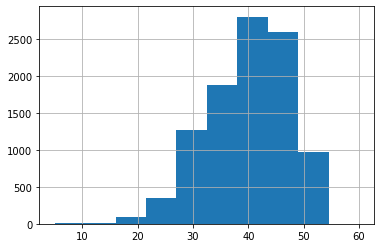

In [4]:
news['headline_text'].str.len().hist()

The histogram shows that news headlines range from 10 to 70 characters and generally, it is between 25 to 55 characters.

In [5]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

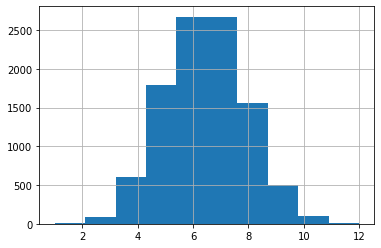

In [6]:
plot_word_number_histogram(news['headline_text'])

It is clear that the number of words in news headlines ranges from 2 to 12 and mostly falls between 5 to 7 words.

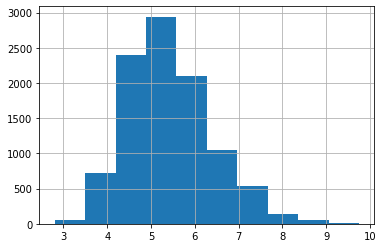

In [7]:
news['headline_text'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

The average word length ranges between 3 to 9 with 5 being the most common length.

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mutlutoy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop = set(stopwords.words('english'))

In [10]:
corpus=[]
new= news['headline_text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [11]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

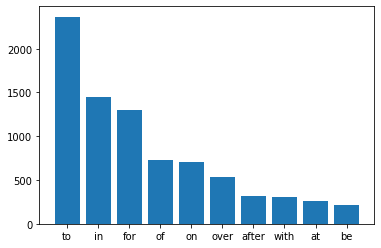

In [12]:
plot_top_stopwords_barchart(news['headline_text'])

We can evidently see that stopwords such as “to”,” in” and “for” dominate in news headlines.

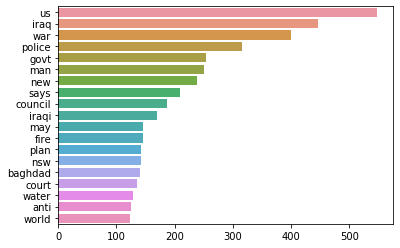

In [13]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

Wow! The “us”, “Iraq” and “war” dominate the headlines over the last 15 years.

Here ‘us’ could mean either the USA or us (you and me). us is not a stopword, but when we observe other words in the graph they are all related to the US – Iraq war and “us” here probably indicate the USA.

In [14]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

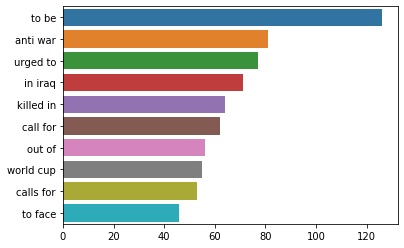

In [15]:
top_n_bigrams=get_top_ngram(news['headline_text'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

We can observe that the bigrams such as ‘anti-war’, ’killed in’ that are related to war dominate the news headlines.

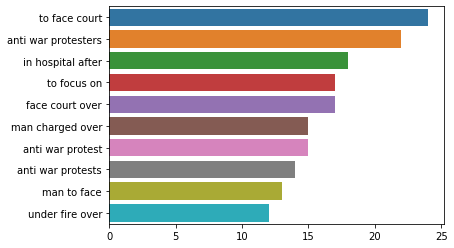

In [16]:
top_tri_grams=get_top_ngram(news['headline_text'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

We can see that many of these trigrams are some combinations of “to face court” and “anti war protest”. It means that we should put some effort into data cleaning and see if we were able to combine those synonym terms into one clean token.

### Topic Modeling exploration with pyLDAvis

In [17]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/mutlutoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mutlutoy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['headline_text']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(news)

In [19]:
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [20]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.009*"world" + 0.007*"cup" + 0.006*"govt" + 0.005*"water" + 0.005*"concern" + 0.005*"boost" + 0.004*"rain" + 0.004*"fire" + 0.004*"war" + 0.004*"farmer"'),
 (1,
  '0.016*"iraq" + 0.007*"govt" + 0.007*"iraqi" + 0.007*"say" + 0.006*"troop" + 0.006*"war" + 0.006*"lead" + 0.006*"attack" + 0.005*"back" + 0.005*"new"'),
 (2,
  '0.018*"iraq" + 0.009*"police" + 0.007*"claim" + 0.007*"sars" + 0.006*"death" + 0.006*"win" + 0.005*"case" + 0.005*"war" + 0.005*"killed" + 0.005*"fire"'),
 (3,
  '0.015*"war" + 0.014*"man" + 0.009*"baghdad" + 0.007*"anti" + 0.006*"police" + 0.006*"face" + 0.006*"plan" + 0.005*"protest" + 0.005*"council" + 0.005*"court"')]

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.083902 -0.149111       1        1  27.115541
1      0.007984  0.121763       2        1  25.506634
0     -0.177796 -0.034846       3        1  24.294163
2      0.085909  0.062194       4        1  23.083666, topic_info=     Category        Freq     Term       Total  loglift  logprob
43    Default  424.000000     iraq  424.000000  30.0000  30.0000
317   Default  206.000000      man  206.000000  29.0000  29.0000
488   Default  111.000000    world  111.000000  28.0000  28.0000
766   Default   85.000000      cup   85.000000  27.0000  27.0000
422   Default  145.000000    claim  145.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
206    Topic4   25.229717  england   43.112854   0.9302  -6.1456
228    Topic4   31.658894    crash   90.991623   0.4103  -5.9186
414    Topic4   30.806055    woman   90.454781   0.3889  -5.9459
3495   Topic4   34.674473  baghdad  198.822556  -0.2804  -5.8276
467    Topic4   34.629681      say  216.037338  -0.3647  -5.8289

[292 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
715       4  0.954046  accuses
1759      3  0.939704   across
1951      3  0.940588  african
1745      1  0.945081     aged
1745      2  0.067506     aged
...     ...       ...      ...
414       1  0.243215    woman
414       2  0.121608    woman
414       3  0.298492    woman
414       4  0.342713    woman
488       3  0.988043    world

[459 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

On the left side, the area of each circle represents the importance of the topic relative to the corpus. As there are four topics, we have four circles.

The distance between the center of the circles indicates the similarity between the topics. Here you can see that the topic 3 and topic 4 overlap, this indicates that the topics are more similar.

On the right side, the histogram of each topic shows the top 30 relevant words. For example, in topic 1 the most relevant words are police, new, may, war, etc

### Wordcloud

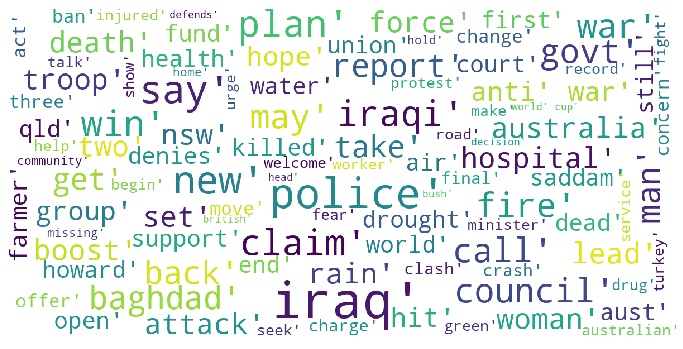

In [22]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

You can see that the terms associated with the war are highlighted which indicates that these words occurred frequently in the news headlines.

## Sentiment Analysis

In [23]:
TextBlob('100 people killed in Iraq').sentiment

Sentiment(polarity=-0.2, subjectivity=0.0)

TextBlob claims that the text “100 people killed in Iraq” is negative and is not an opinion or feeling but rather a factual statement. I think we can agree with TextBlob here.

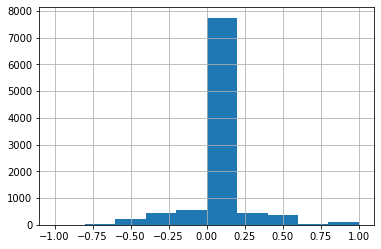

In [24]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['headline_text'].\
   apply(lambda x : polarity(x))
news['polarity_score'].hist()

You can see that the polarity mainly ranges between 0.00 and 0.20. This indicates that the majority of the news headlines are neutral.

<BarContainer object of 3 artists>

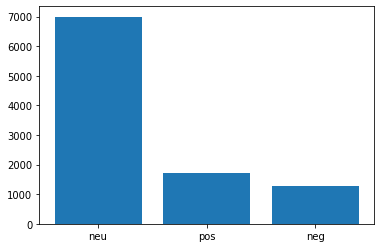

In [25]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
news['polarity']=news['polarity_score'].\
   map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

70 % of news is neutral with only 18% of positive and 11% of negative.

Let’s take a look at some of the positive and negative headlines.

In [26]:
news[news['polarity']=='pos']['headline_text'].head()

1     act fire witnesses must be aware of defamation
5                  ambitious olsson wins triple jump
6         antic delighted with record breaking barca
18        bryant leads lakers to double overtime win
26      commonwealth bank cuts fixed home loan rates
Name: headline_text, dtype: object

Positive news headlines are mostly about some victory in sports.

In [27]:
news[news['polarity']=='neg']['headline_text'].head()

7     aussie qualifier stosur wastes four memphis match
23               carews freak goal leaves roma in ruins
28     council chief executive fails to secure position
34                   dargo fire threat expected to rise
40        direct anger at govt not soldiers crean urges
Name: headline_text, dtype: object

Negative news headlines.

### Vader Sentiment Analysis

In [28]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mutlutoy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

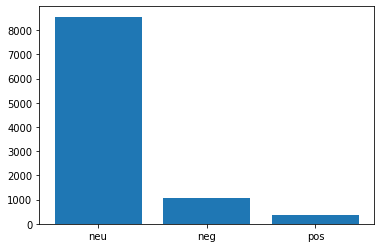

In [29]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

There is a slight difference in distribution. Even more headlines are classified as neutral 85 % and the number of negative news headlines has increased (to 12 %).

### Named Entity Recognition

In [35]:
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/opt/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [36]:
nlp = spacy.load("en_core_web_sm")

In [38]:
from spacy import displacy

In [39]:
def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)

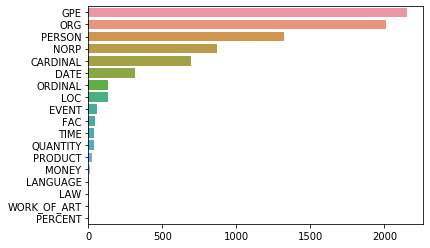

In [40]:
plot_named_entity_barchart(news['headline_text'])

Now we can see that the GPE and ORG dominate the news headlines followed by the PERSON entity.

We can also visualize the most common tokens per entity. Let’s check which places appear the most in news headlines.

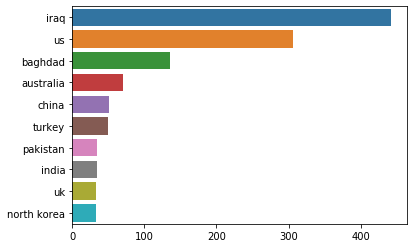

In [41]:
def ner(text,ent="GPE"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe=news['headline_text'].apply(lambda x: ner(x))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

Let’s also find the most common names that appeared in news headlines.

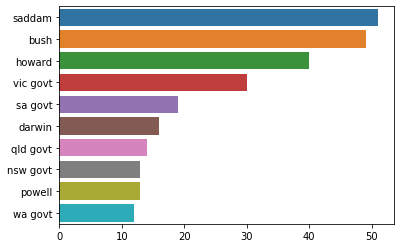

In [42]:
per=news['headline_text'].apply(lambda x: ner(x,"PERSON"))
per=[i for x in per for i in x]
counter=Counter(per)

x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

### Exploration through Parts of Speach (POS) Tagging 

Parts of speech (POS) tagging is a method that assigns part of speech labels to words in a sentence. There are eight main parts of speech:

Noun (NN)- Joseph, London, table, cat, teacher, pen, city

Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is

Adjective(JJ)- beautiful, happy, sad, young, fun, three

Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow

Preposition (IN)- at, on, in, from, with, near, between, about, under

Conjunction (CC)- and, or, but, because, so, yet, unless, since, if

Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this

Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

Let’s use POS tagging to explore our headlines dataset.

In [44]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mutlutoy/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

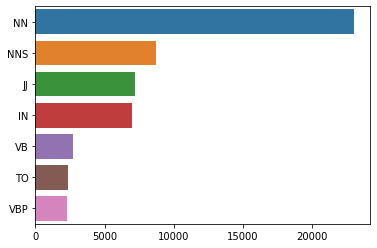

In [45]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags=news['headline_text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

We can clearly see that the noun (NN) dominates in news headlines followed by the adjective (JJ). 

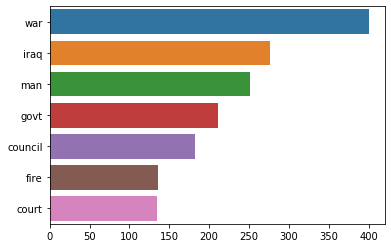

In [46]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words=news['headline_text'].apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

Nouns such as “war”, “iraq”, “man” dominate in the news headlines.